In [1]:
import numpy as np
import h5py
import string
import matplotlib.pyplot as plt 
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Meta data of papers
class PaperMeta(object):
    def __init__(self, title, abstract, keyword, rating):
        self.title = title  # str
        self.abstract = abstract  # str
        self.keyword = keyword  # list[str]
        self.rating = rating  # list[int]
        
        if len(self.rating) > 0:
            self.average_rating = np.mean(rating)
        else:
            self.average_rating = -1

def write_meta(meta_list, filename):
    f = h5py.File(filename, 'w')
    for i, m in enumerate(meta_list):
        grp = f.create_group(str(i))
        grp['title'] = m.title
        grp['abstract'] = m.abstract
        grp['keyword'] = '#'.join(m.keyword)
        grp['rating'] = m.rating
    f.close()
    
def read_meta(filename):
    f = h5py.File(filename, 'r')
    meta_list = []
    for k in list(f.keys()):
        meta_list.append(PaperMeta(
            f[k]['title'].value, 
            f[k]['abstract'].value, 
            f[k]['keyword'].value.split('#'),
            f[k]['rating'].value
        ))
    return meta_list

def crawl_meta(meta_hdf5=None, write_meta_name='data.hdf5'):
    
    if meta_hdf5 is None:
        # Crawl the meta data from OpenReview
        # Set up a browser to crawl from dynamic web pages 
        from selenium import webdriver
        from selenium.webdriver.chrome.options import Options
        import time
        executable_path = '/Users/waltersun/Desktop/chromedriver'
        options = Options()
        options.add_argument("--headless")
        browser = webdriver.Chrome(options=options, executable_path=executable_path)            
    
        # Load all URLs for all ICLR submissions
        urls = []
        with open('urls.txt') as f:
            urls = f.readlines()
        urls = [url.strip() for url in urls]
    
        meta_list = [] 
        fail_list = []
        for i, url in enumerate(urls):
            try:
                browser.get(url)
                time.sleep(2)
                # title
                title = string.capwords(browser.find_element_by_class_name("note_content_title").text)
                # abstract
                abstract = ' '.join(browser.find_elements_by_class_name("note_content_value")[0].text.split('\n'))
                # keyword
                keyword = browser.find_elements_by_class_name("note_content_value")[1].text.split(',')
                keyword = [k.strip(' ') for k in keyword]
                keyword = [''.join(string.capwords(k).split(' ')) for k in keyword]
                # rating
                notes = browser.find_elements_by_class_name("note_with_children")
                rating = []
                for note in notes:
                    if 'Confidence: ' in note.text and 'Rating:' in note.text:
                        rating.append(int(note.text.split('Rating:')[-1].split('Confidence: ')[0].strip().split(':')[0]))
                print('[{}] {} {}'.format(i, title, rating))
                meta_list.append(PaperMeta(title, abstract, keyword, rating))
            except:
                fail_list.append(url)
        # Save the crawled data
        write_meta(meta_list, write_meta_name)
    else:
        # Load the meta data from local
        meta_list = read_meta(meta_hdf5)
        fail_list = []
    return meta_list, fail_list

In [3]:
# Get the meta data
meta_list, _ = crawl_meta('data.hdf5')

In [4]:
ratings = []
ratings_mean = []
keywords = []
for m in meta_list:
    ratings.extend(m.rating)
    keywords.extend(m.keyword)
    if len(m.rating) > 0:
        ratings_mean.append(m.average_rating)
print('Average rating: {}'.format(np.mean(ratings)))

Average rating: 5.145391818629867


Text(0.5,0,'Rating per paper hist')

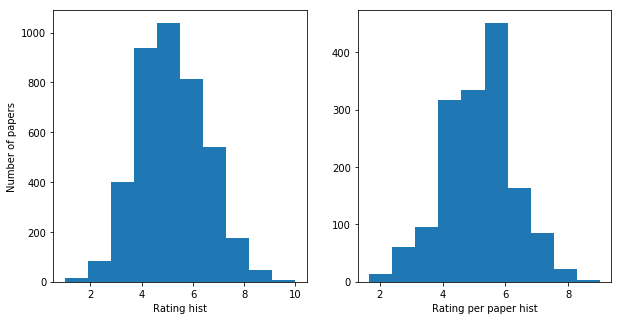

In [5]:
# Plot histograms of ratings
fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.xlabel('Rating hist')
plt.ylabel('Number of papers')
plt.hist(ratings, bins=10)
plt.subplot(122)
plt.hist(ratings_mean, bins=10)
plt.xlabel('Rating per paper hist')

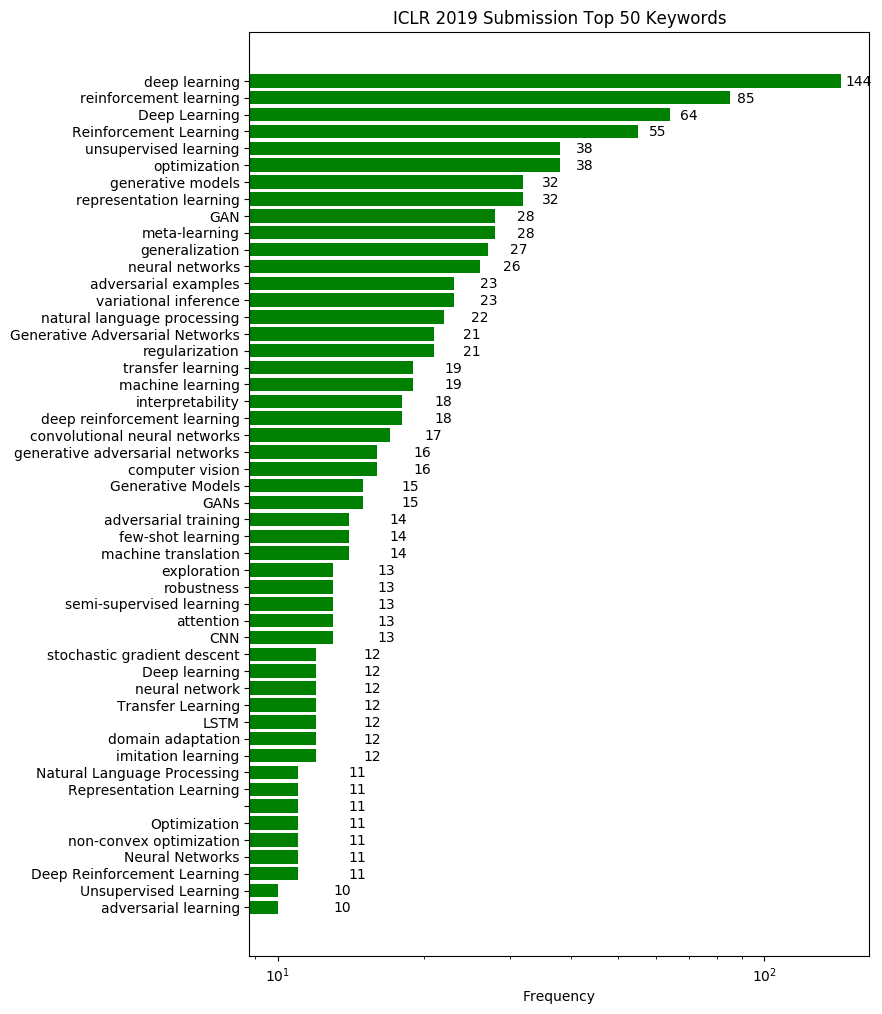

In [6]:
# Show 50 most common keywords and their frequencies
from collections import Counter
num_keyowrd = 50
keywords_hist = Counter(keywords).most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))

key = [k[0] for k in keywords_hist] 
value = [k[1] for k in keywords_hist] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .28, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('ICLR 2019 Submission Top {} Keywords'.format(num_keyowrd))

plt.show()

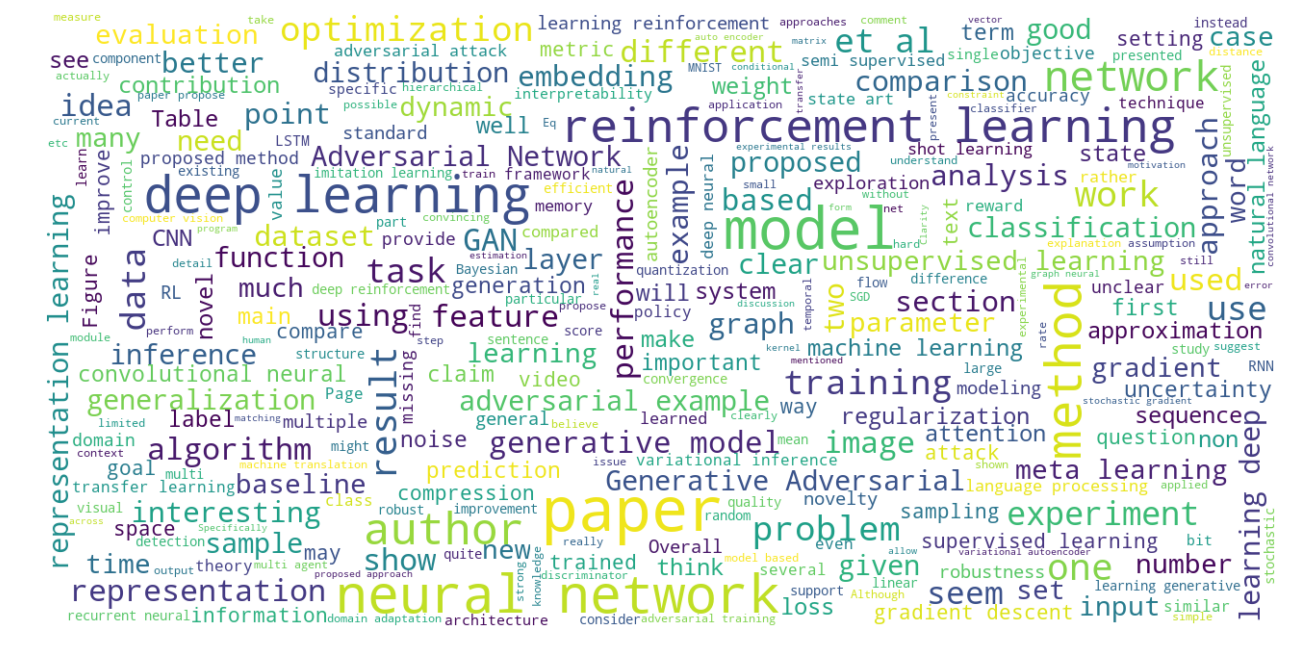

In [7]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=300, 
                      width=1280, height=640,
                      background_color="white").generate(' '.join(keywords))
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

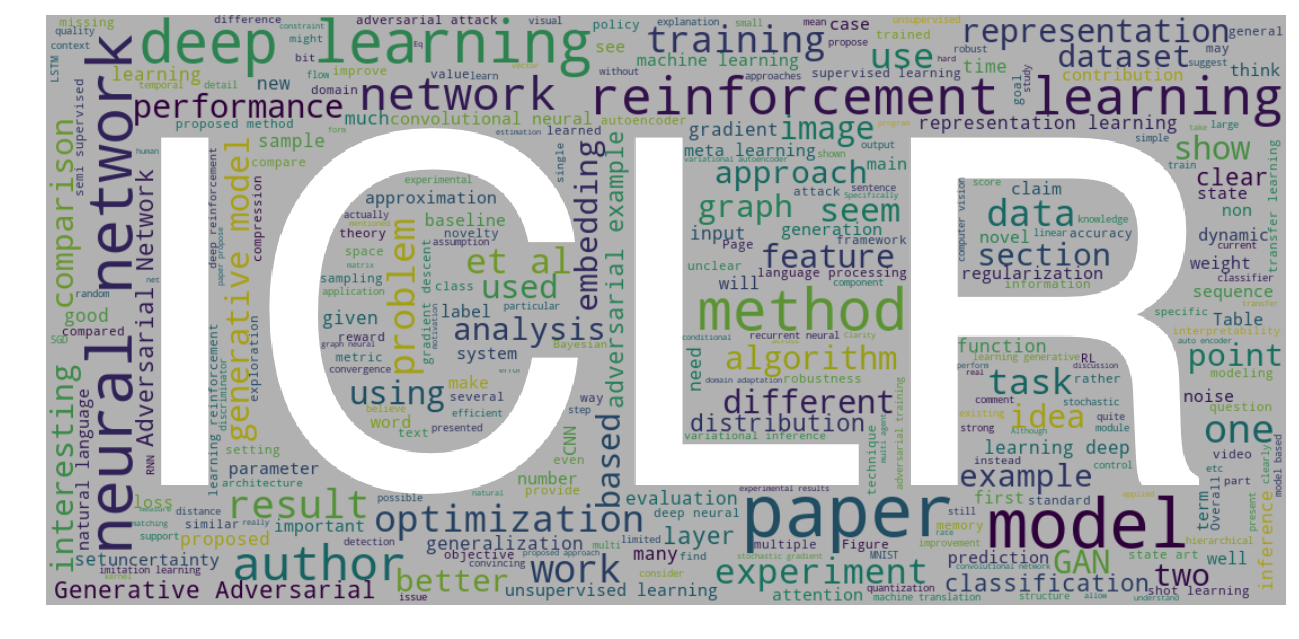

In [8]:
# Show the word cloud with an ICLR logo
from imageio import imread
logo = imread('logo.png')
wordcloud = WordCloud(max_font_size=64, max_words=300, 
                      width=1280, height=640,
                      background_color="white", mask=logo).generate(' '.join(keywords))
plt.figure(figsize=(16, 8), frameon=False)
plt.imshow(logo)
plt.imshow(wordcloud, interpolation="bilinear",  alpha=.7)
plt.axis("off")
plt.show()